# The COVID-19 Case rising due to overseas travel and community transmissiom
This notebook will analysis the Covid case due to the overseas travel and community transmission. This analysis show international travel and community transmission inside the country is the reason for spreading the increasing case. After finishing this analysis, the final result will connect with the analysis of study case of lockdown country.

In [3]:
import pandas as pd
from pandas import read_excel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model      import LogisticRegression
from sklearn                   import linear_model
from sklearn.metrics           import confusion_matrix, accuracy_score, r2_score, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree
from scipy.spatial.distance import pdist 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

## The dataset
There are two datasets using to this analysis which collect the introduce about oversea travel in each country in every different time, other dataset is the information of covid-19 cases each day from the started outbreak until now. Two datasets are taken from [Oxford University](https://ourworldindata.org/) about time series covid-cases and covid-19 government measure dataset from [Acaps](https://www.acaps.org/covid-19-government-measures-dataset).

In [4]:
# Read the datasets
df1 = pd.read_excel(open('data/covid-19 measure.xlsx', 'rb'),sheet_name='Dataset')
df2 = pd.read_csv("files/owid-covid-data.csv")

In [5]:
# Read first dataset
df1.head()

,ID,ISO,COUNTRY,REGION,ADMIN_LEVEL_NAME,PCODE,LOG_TYPE,CATEGORY,MEASURE,TARGETED_POP_GROUP,COMMENTS,NON_COMPLIANCE,DATE_IMPLEMENTED,SOURCE,SOURCE_TYPE,LINK,ENTRY_DATE,Alternative source
0,4245,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Public health measures,Awareness campaigns,NaN,MoPH begins announcements on their facebook to...,NaN,2020-01-24,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/posts/1005130...,2020-04-07,NaN
1,4246,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Public health measures,Health screenings in airports and border cross...,checked,Health teams at airports will check passengers...,NaN,2020-01-26,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/posts/1006458...,2020-04-07,NaN
2,4247,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Movement restrictions,International flights suspension,checked,Flights to China are suspended.,NaN,2020-01-27,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/photos/a.4625...,2020-04-07,NaN
3,4248,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Public health measures,Health screenings in airports and border cross...,NaN,Health screenings of all passengers at airports.,NaN,2020-01-27,Afghanistan MoPH,Government,https://www.facebook.com/af.moph/photos/a.4625...,2020-04-07,NaN
4,23,AFG,Afghanistan,Asia,NaN,NaN,Introduction / extension of measures,Movement restrictions,Border checks,checked,All China and Iran nationals,NaN,2020-02-01,US Embassy,Government,https://af.usembassy.gov/covid-19-information/,2020-03-14,NaN


In [6]:
# change data type of column 'DATE_IMPLEMENTED' to datetime
df1['DATE_IMPLEMENTED'] = pd.to_datetime(df1['DATE_IMPLEMENTED'])

In [7]:
# change data type of column 'date' to datatime and read second dataset
df2['date'] = pd.to_datetime(df2['date'])
df2

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125960,ZWE,Africa,Zimbabwe,2021-10-20,132437.0,32.0,47.000,4659.0,0.0,1.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125961,ZWE,Africa,Zimbabwe,2021-10-21,132540.0,103.0,41.286,4662.0,3.0,1.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125962,ZWE,Africa,Zimbabwe,2021-10-22,132588.0,48.0,43.286,4663.0,1.0,1.143,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
125963,ZWE,Africa,Zimbabwe,2021-10-23,132588.0,0.0,36.429,4663.0,0.0,0.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


## The data cleaning and choosen

This sample choose ten countries for this analysis. In the measure, Border closure represent for community transmission and Limit public gatherings represent for Oversea travel. To more specific, if the day border closure has higher number of daily cases than limit public gatherings, it will show that the community transmission will be the main reason for spreading quickly covid-19.
###### Explain dataset
* COUNTRY: ten countries choosen for sample
* REGION: the are of ten countries from
* MEASURE: the measure of goverment help to reduce covid cases
* DATE_IMPLEMENTED: the day starts measure
* total_cases: total cases from the previous until that day
* new_cases: the new covid cases daily

In [8]:
# drop columns unnessesary to analysis
measure=df1.drop(columns=['ID', 'ISO','ADMIN_LEVEL_NAME','PCODE','LOG_TYPE','TARGETED_POP_GROUP','NON_COMPLIANCE','LINK','SOURCE_TYPE','ENTRY_DATE','Alternative source','COMMENTS','SOURCE','CATEGORY'])
measure.head()

,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED
0,Afghanistan,Asia,Awareness campaigns,2020-01-24
1,Afghanistan,Asia,Health screenings in airports and border cross...,2020-01-26
2,Afghanistan,Asia,International flights suspension,2020-01-27
3,Afghanistan,Asia,Health screenings in airports and border cross...,2020-01-27
4,Afghanistan,Asia,Border checks,2020-02-01


In [9]:
# choose ten countries and mesure of control covid 
country1 = measure["COUNTRY"].isin(
["Argentina", "Germany", "France", "Spain", "United States","Turkey","Brazil","Russia","Colombia","Ukraine"])
measr = measure["MEASURE"].isin([ "Border closure","Limit public gatherings"])
cmeasure = measure[measr & country1]
cmeasure

,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED
664,Argentina,Americas,Limit public gatherings,2020-03-12
671,Argentina,Americas,Limit public gatherings,2020-03-19
681,Argentina,Americas,Border closure,2020-03-26
682,Argentina,Americas,Border closure,2020-03-26
692,Argentina,Americas,Border closure,2020-04-01
...,...,...,...,...
23235,United States,Americas,Border closure,2020-09-23
23238,United States,Americas,Border closure,2020-09-30
23251,United States,Americas,Limit public gatherings,2020-10-08
23280,United States,Americas,Border closure,2020-10-22


In [10]:
#Set index by column'DATE_IMPLEMENTED' so that in can display all the day has daily covid when merge to table
def reset_idx(df, col):
    df.set_index(col, inplace=True) #reset index
    return df
#Create a list containing daily data
df_list=[]
for i in cmeasure['COUNTRY'].unique():
    df=cmeasure[cmeasure['COUNTRY']==i]
    reset_idx(df, 'DATE_IMPLEMENTED') 
    idx = pd.date_range(start=df.index.min(), end=df.index.max()) #create daily range 
    df.index = pd.DatetimeIndex(df.index)
    idx_non_dup = np.unique( df.index.values, return_index = True )[1]
    df = df.iloc[idx_non_dup]
    df = df.reindex(idx) #change index to daily data
    df.ffill(inplace=True) #Fill missing value by previous row values
    df['DATE_IMPLEMENTED']=pd.DatetimeIndex(df.index)
    df_list.append(df)
df_list
#Add all country dataframe together
Fcase=df_list[0].append(df_list[1:])
Fcase

,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED
2020-03-12,Argentina,Americas,Limit public gatherings,2020-03-12
2020-03-13,Argentina,Americas,Limit public gatherings,2020-03-13
2020-03-14,Argentina,Americas,Limit public gatherings,2020-03-14
2020-03-15,Argentina,Americas,Limit public gatherings,2020-03-15
2020-03-16,Argentina,Americas,Limit public gatherings,2020-03-16
...,...,...,...,...
2020-10-18,United States,Americas,Limit public gatherings,2020-10-18
2020-10-19,United States,Americas,Limit public gatherings,2020-10-19
2020-10-20,United States,Americas,Limit public gatherings,2020-10-20
2020-10-21,United States,Americas,Limit public gatherings,2020-10-21


In [11]:
# drop columns unnessesary from covid data and change the name of columns
df2.drop(df2.columns.difference(['date','location', 'total_cases', 'new_cases', 'continnent']), 1, inplace=True)
dict = {'location': 'COUNTRY',
        'date': 'DATE_IMPLEMENTED'}
df2.rename(columns=dict,inplace=True)
df2

,COUNTRY,DATE_IMPLEMENTED,total_cases,new_cases
0,Afghanistan,2020-02-24,5.0,5.0
1,Afghanistan,2020-02-25,5.0,0.0
2,Afghanistan,2020-02-26,5.0,0.0
3,Afghanistan,2020-02-27,5.0,0.0
4,Afghanistan,2020-02-28,5.0,0.0
...,...,...,...,...
125960,Zimbabwe,2021-10-20,132437.0,32.0
125961,Zimbabwe,2021-10-21,132540.0,103.0
125962,Zimbabwe,2021-10-22,132588.0,48.0
125963,Zimbabwe,2021-10-23,132588.0,0.0


In [12]:
# join two tables to create new table with total case and the measure
case = pd.merge(Fcase, df2, on=['COUNTRY', 'DATE_IMPLEMENTED'], how = 'left')
case

,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases
0,Argentina,Americas,Limit public gatherings,2020-03-12,19.0,0.0
1,Argentina,Americas,Limit public gatherings,2020-03-13,31.0,12.0
2,Argentina,Americas,Limit public gatherings,2020-03-14,34.0,3.0
3,Argentina,Americas,Limit public gatherings,2020-03-15,45.0,11.0
4,Argentina,Americas,Limit public gatherings,2020-03-16,56.0,11.0
...,...,...,...,...,...,...
2304,United States,Americas,Limit public gatherings,2020-10-18,8166861.0,50808.0
2305,United States,Americas,Limit public gatherings,2020-10-19,8233937.0,67076.0
2306,United States,Americas,Limit public gatherings,2020-10-20,8295638.0,61701.0
2307,United States,Americas,Limit public gatherings,2020-10-21,8358792.0,63154.0


## Data Visualizing
This part will display some graph to see the relationship between total cases, new cases and measure about the data of 10 countries

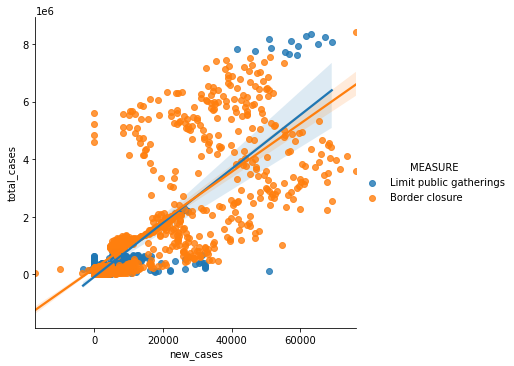

In [13]:
sns.lmplot(x = 'new_cases', y = 'total_cases',hue = 'MEASURE', data = case)

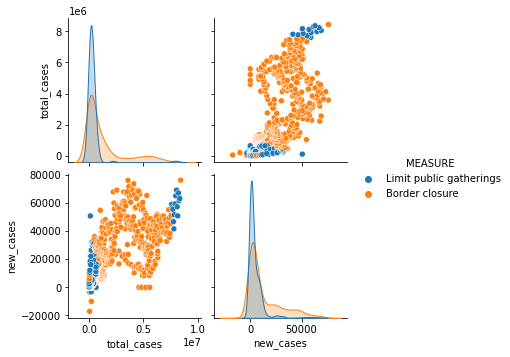

In [14]:
sns.pairplot(case, hue = 'MEASURE')

As can be seen in the graph, the volume of new cases caused by border closure in much larger than cases recorded by public restrictions. Moreover, the firgure shows that there is a positive relationship in the graph since at the time cases increased by overseas travel, the new cases by community transmission grew significantly and went down when the border is restricted. Therefore, it can be explained that border closure could be seen as a origin reason that brought to another outbreak.   

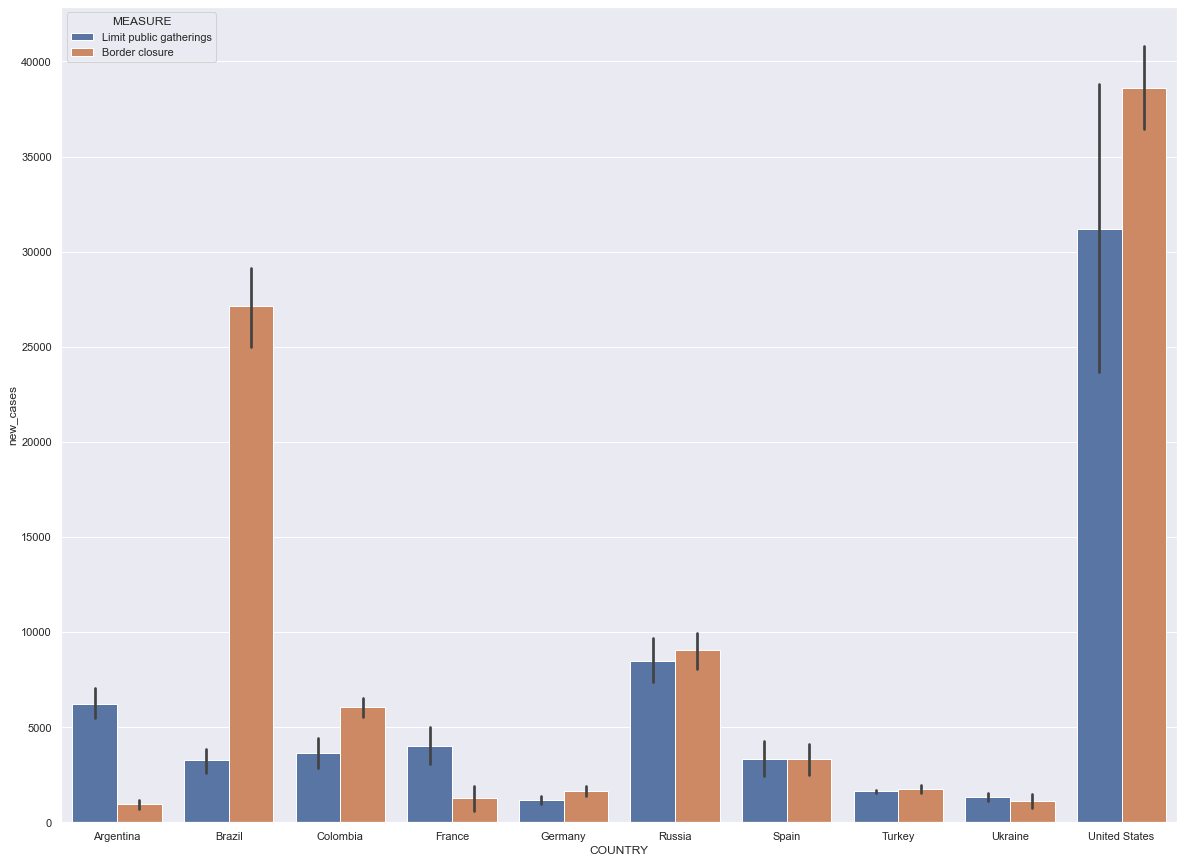

In [99]:
sns.barplot(x="COUNTRY", y='new_cases',hue="MEASURE", data=case)
sns.set(rc={'figure.figsize':(25,15)})

The bar chart demonstrates that Covid cases in Brazil and United State are affected the most by overseas travelling since the firgures in these two countries are seen at a considerable number, especially America that also has a high number of cases caused by community spread. Furtheremore, a larger percentage of new cases raise by external travel are wittnessed among selected countries excepting Argentina and France. Besides, although Brazil has a high rate of infected cases but the number of people exposed by community transmission is controlled.

### The effect of 2 measures following the percentage of new cases in total cases in the date implemented 

In this part, we will display data visualizing about the effect of Limit public gatherings and Border closure. Each day will have the measure implemented and new cases daily, hence the percentage is counted to consider oversea travel and community tranmission can make raise the cases. 
* Percentage show us in the date implemented for Limit public gatherings and Border closure, which measure has the highest number of covid cases daily in the total cases.
* The measure which have the rising trend will be the most effective in the total cases. If the limit public gatherings has the upward trend, it means oversea travel can be the reason for the outbreak, vice versa.

In [16]:
case['Percentage'] = case['new_cases']/ case['total_cases']
case

,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases,Percentage
0,Argentina,Americas,Limit public gatherings,2020-03-12,19.0,0.0,0.000000
1,Argentina,Americas,Limit public gatherings,2020-03-13,31.0,12.0,0.387097
2,Argentina,Americas,Limit public gatherings,2020-03-14,34.0,3.0,0.088235
3,Argentina,Americas,Limit public gatherings,2020-03-15,45.0,11.0,0.244444
4,Argentina,Americas,Limit public gatherings,2020-03-16,56.0,11.0,0.196429
...,...,...,...,...,...,...,...
2304,United States,Americas,Limit public gatherings,2020-10-18,8166861.0,50808.0,0.006221
2305,United States,Americas,Limit public gatherings,2020-10-19,8233937.0,67076.0,0.008146
2306,United States,Americas,Limit public gatherings,2020-10-20,8295638.0,61701.0,0.007438
2307,United States,Americas,Limit public gatherings,2020-10-21,8358792.0,63154.0,0.007555


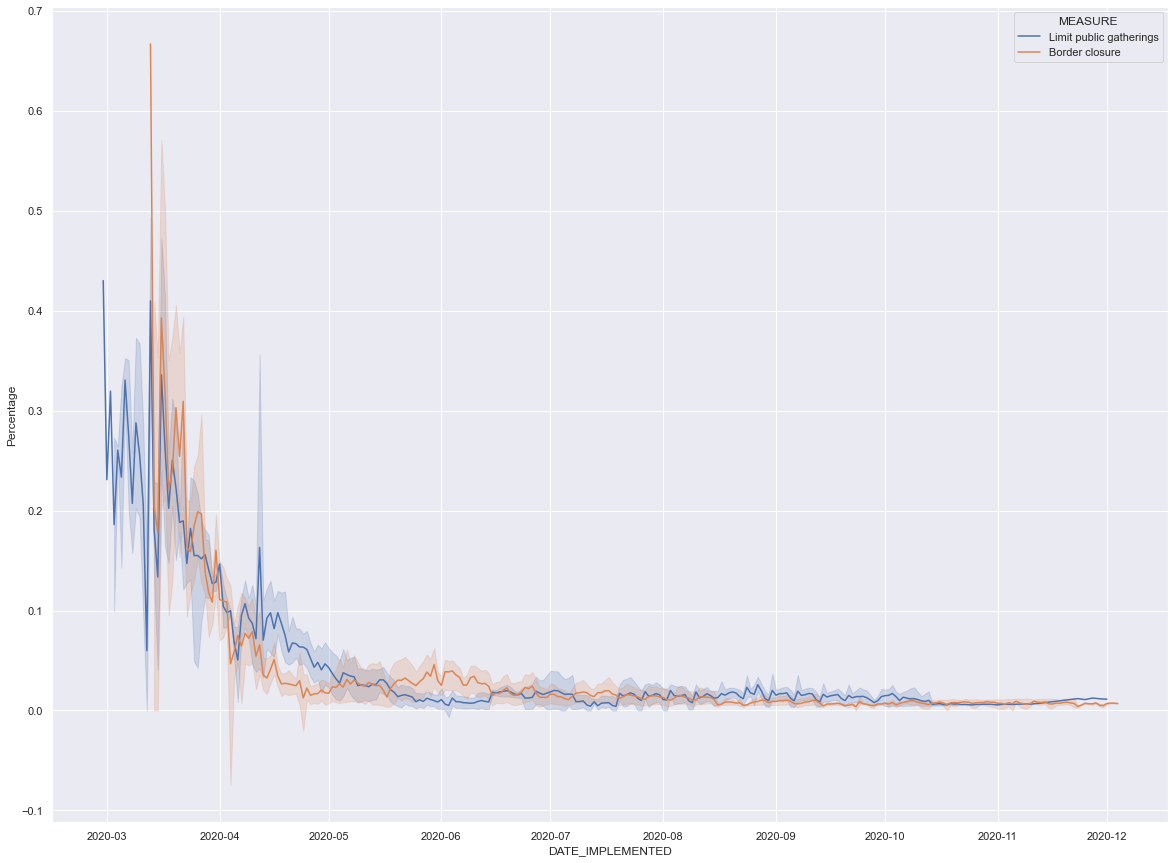

In [17]:
sns.lineplot(x = "DATE_IMPLEMENTED", y = "Percentage",hue="MEASURE" ,data = case)
plt.show()

* Look at this graph, the number of new cases in the date implemented border closure is higher than limit public gatherings from mid March until April. Moving the first period, limit public gatherings is familliar to control covid-19. However, seeing the problems from oversea travel can bring more the new cases and hardly to control, border closure is the good option at that point but the limit public gatherings inside their area are no longer hard like the first time, so daily cases increase quickly become the top of graphs and through out of the period, the date implemented border closure remains the highest number.

###### Unites States will be an example for a clearly outlook for the effect of two measures in the increasing covid cases daily

In [18]:
set(case['REGION'])

{'Americas', 'Europe', 'Middle east'}

In [19]:
#Sorting out data by region
case_Americas=case[case['REGION'].isin(['Americas'])]
case_Americas=case_Americas[case['MEASURE'].isin(['Border closure','Limit public gatherings'])]
case_Americas.head()

<ipython-input-19-e8645fc95f1a>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  case_Americas=case_Americas[case['MEASURE'].isin(['Border closure','Limit public gatherings'])]


,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases,Percentage
0,Argentina,Americas,Limit public gatherings,2020-03-12,19.0,0.0,0.000000
1,Argentina,Americas,Limit public gatherings,2020-03-13,31.0,12.0,0.387097
2,Argentina,Americas,Limit public gatherings,2020-03-14,34.0,3.0,0.088235
3,Argentina,Americas,Limit public gatherings,2020-03-15,45.0,11.0,0.244444
4,Argentina,Americas,Limit public gatherings,2020-03-16,56.0,11.0,0.196429


In [20]:
set(case_Americas['COUNTRY'])

{'Argentina', 'Brazil', 'Colombia', 'United States'}

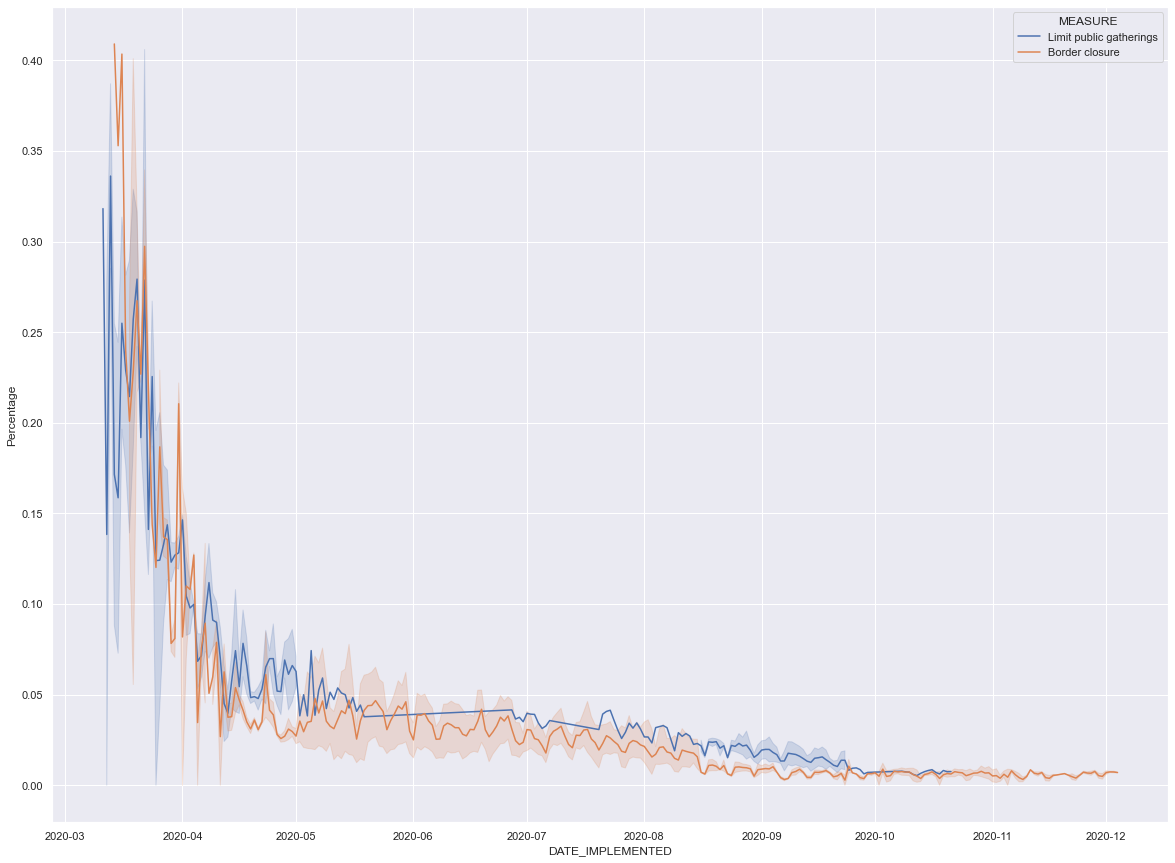

In [21]:
sns.lineplot(x = "DATE_IMPLEMENTED", y = "Percentage",hue="MEASURE" ,data = case_Americas)
plt.show()

* Americas region in the first period they implemented limit public gatherings but the cases remains the largest and did not have the downward trend.At the time decided to close the border, loosing the community transmission is the reason made the number of covid cases at the highest point but after that these is a decrease sharply in cases and remains lower numbers. 

In [22]:
case_Americas_US= case_Americas[case_Americas['COUNTRY'].isin(['United States'])]

C:\Users\nguye\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

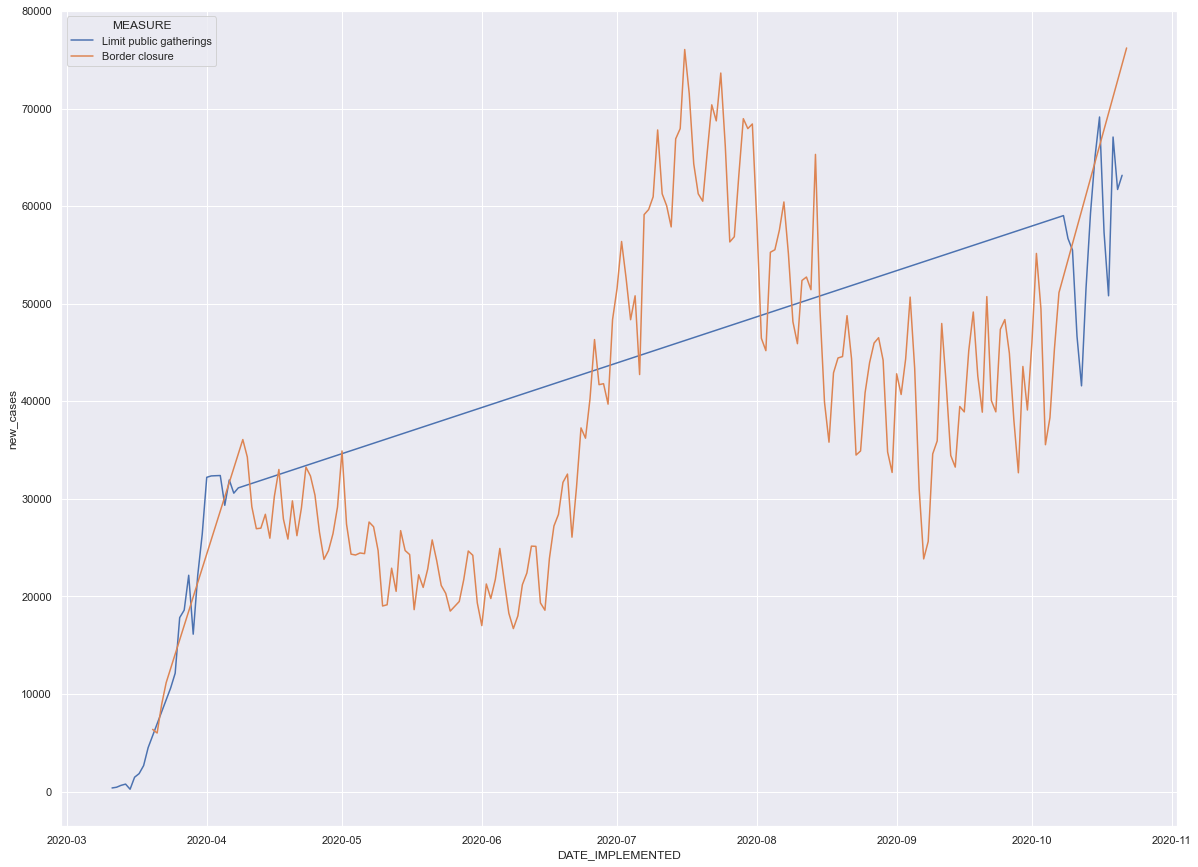

In [23]:
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=case_Americas_US)

At the time having the first covid-19 case, US decided choose limit public gathering and remaining the oversea travel so that the number of cases rising suddenly. Hence, border closure introduced at that time, but take 14 days to have incubation period the number of cases continue go up. In the trend of border closure, the case in community transmission from the people other countries make US having an outbreak.

##### Europe

In [24]:
#Sorting out data by region
case_Europe=case[case['REGION'].isin(['Europe'])]
case_Europe=case_Europe[case['MEASURE'].isin(['Border closure','Limit public gatherings'])]
case_Europe.head()

<ipython-input-24-b1e1ec1cffd2>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  case_Europe=case_Europe[case['MEASURE'].isin(['Border closure','Limit public gatherings'])]


,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases,Percentage
724,France,Europe,Limit public gatherings,2020-02-29,100.0,43.0,0.430000
725,France,Europe,Limit public gatherings,2020-03-01,130.0,30.0,0.230769
726,France,Europe,Limit public gatherings,2020-03-02,191.0,61.0,0.319372
727,France,Europe,Limit public gatherings,2020-03-03,212.0,21.0,0.099057
728,France,Europe,Limit public gatherings,2020-03-04,288.0,76.0,0.263889


In [25]:
set(case_Europe['COUNTRY'])

{'France', 'Germany', 'Russia', 'Spain', 'Ukraine'}

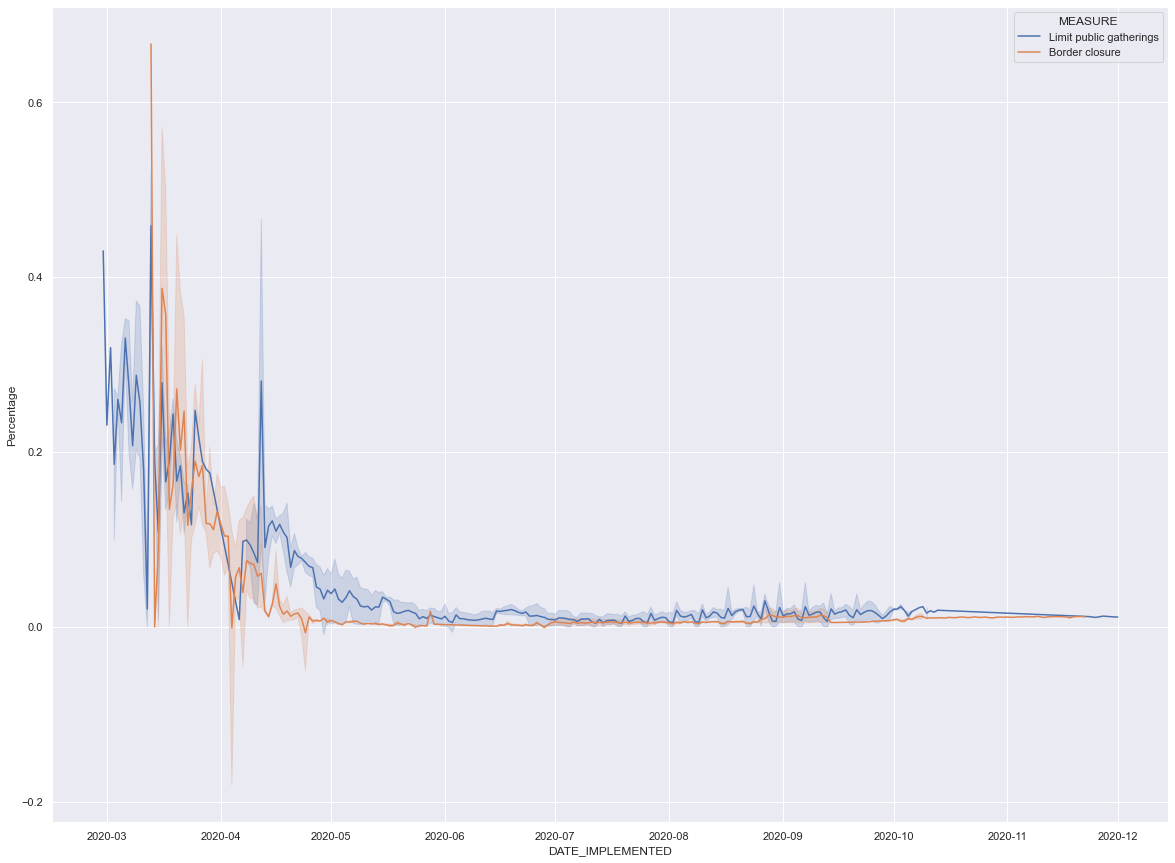

In [26]:
sns.lineplot(x = "DATE_IMPLEMENTED", y = "Percentage",hue="MEASURE" ,data = case_Europe)
plt.show()

* European has the same time period to implemented measures to control covid with Americas, so there is a parallel trend of covid cases 

###### France will be example in Europe to see the effect of two measure in the increasing covid cases daily

In [27]:
case_Europe_France= case_Europe[case_Europe['COUNTRY'].isin(['France'])]

C:\Users\nguye\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

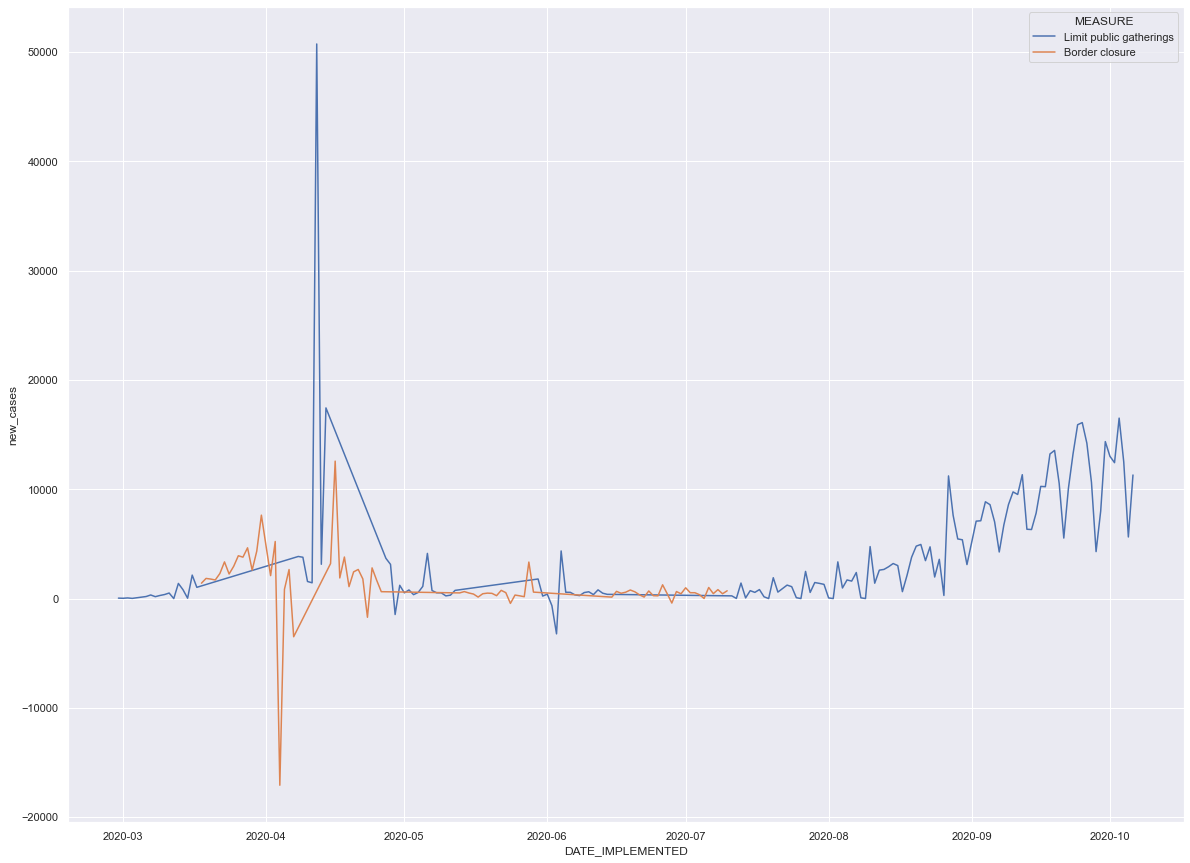

In [28]:
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=case_Europe_France)

* France choosen limit public gatherings is the popular measure to control spreading of covid-19 through the 2020. Hence the upward trend from time to time. In April 2020, when the date implemented border closure, the statistic shows the decreasing number of daily but it suddenly rising in a short time. Compared to two types of measures, France is suitable with the border closure to control covid-19

 ##### Middle East - Russia

In [29]:
case_Russia = case[case['COUNTRY'].isin(['Russia'])]

C:\Users\nguye\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DATE_IMPLEMENTED', ylabel='new_cases'>

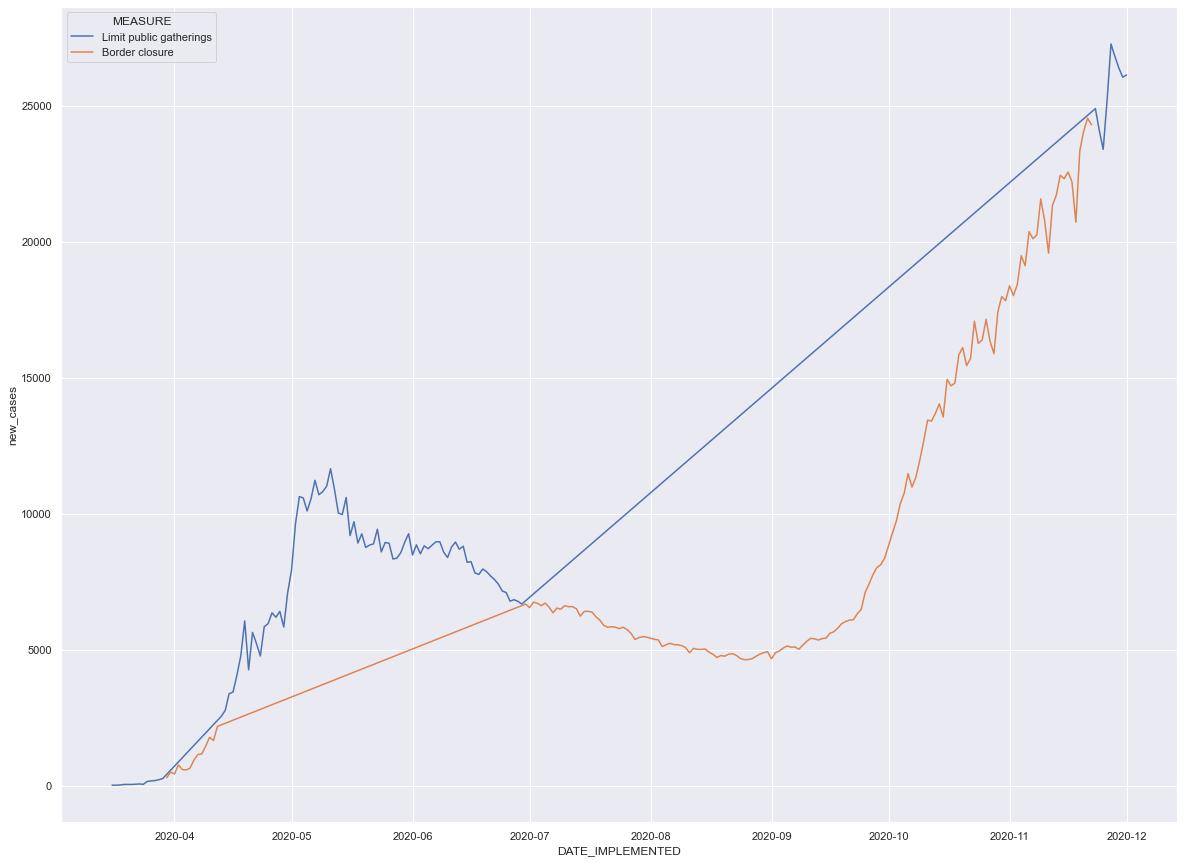

In [30]:
sns.lineplot('DATE_IMPLEMENTED', 'new_cases', hue='MEASURE', data=case_Russia)

In Russia, two measures has both an upward trend in the number of cases. In border closure, it has a middle time from July to mid Octorber that the cases is lower than limit public gatherings. However it move up suddenly and catch up with limit public gatherings in new cases

## Hierarchical Clustering

Using Hierarchical Clustering to 

In [31]:
case.head()

,COUNTRY,REGION,MEASURE,DATE_IMPLEMENTED,total_cases,new_cases,Percentage
0,Argentina,Americas,Limit public gatherings,2020-03-12,19.0,0.0,0.000000
1,Argentina,Americas,Limit public gatherings,2020-03-13,31.0,12.0,0.387097
2,Argentina,Americas,Limit public gatherings,2020-03-14,34.0,3.0,0.088235
3,Argentina,Americas,Limit public gatherings,2020-03-15,45.0,11.0,0.244444
4,Argentina,Americas,Limit public gatherings,2020-03-16,56.0,11.0,0.196429


In [32]:
# Dropping non-numeric columns from the original datafram
HC_case = case.drop(columns=['REGION','DATE_IMPLEMENTED','Percentage'])

In [33]:
# set column 'Name' as the index of the Dataframe
Hcase = HC_case.set_index('COUNTRY')
Hcase

,MEASURE,total_cases,new_cases
COUNTRY,,,
Argentina,Limit public gatherings,19.0,0.0
Argentina,Limit public gatherings,31.0,12.0
Argentina,Limit public gatherings,34.0,3.0
Argentina,Limit public gatherings,45.0,11.0
Argentina,Limit public gatherings,56.0,11.0
...,...,...,...
United States,Limit public gatherings,8166861.0,50808.0
United States,Limit public gatherings,8233937.0,67076.0
United States,Limit public gatherings,8295638.0,61701.0


In [34]:
Hcase = Hcase.replace({'Limit public gatherings' : 1, 'Border closure': 2})
Hcase.head()

,MEASURE,total_cases,new_cases
COUNTRY,,,
Argentina,1,19.0,0.0
Argentina,1,31.0,12.0
Argentina,1,34.0,3.0
Argentina,1,45.0,11.0
Argentina,1,56.0,11.0


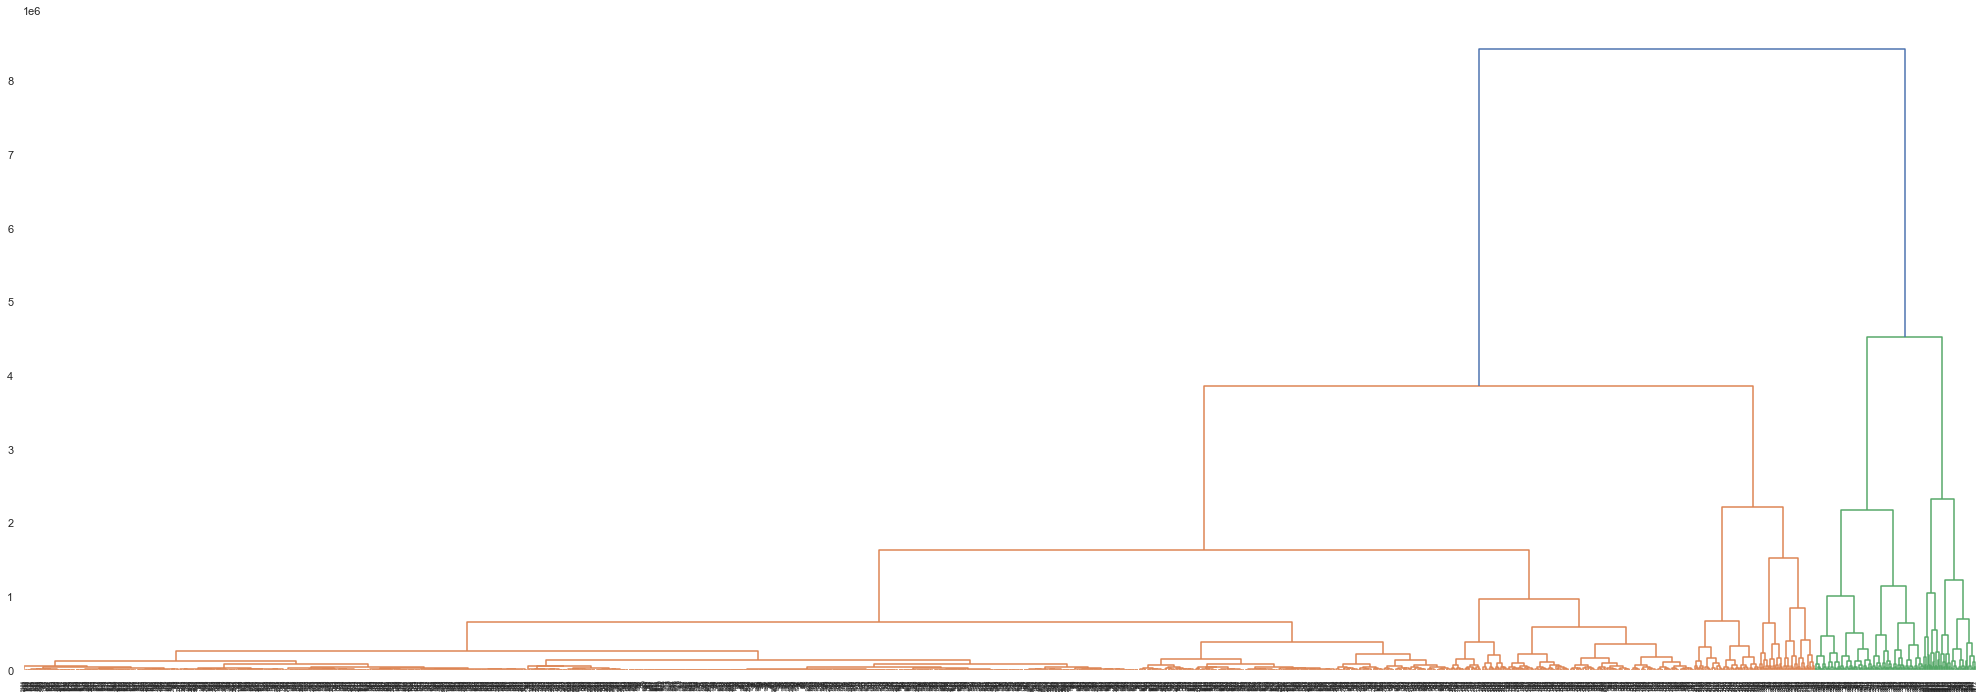

In [103]:
dist = pdist(Hcase, 'euclidean')
linkage_matrix = linkage(dist, method = 'complete')
plt.figure(figsize=(35,12))
dendrogram(linkage_matrix)
plt.show()

Based on the results of hierarchical clustering, this datasets should be groups into two clusters of data to be used in the model. 

In [36]:
labels = cut_tree(linkage_matrix, n_clusters=2)
Hcase['label'] = labels
Hcase

,MEASURE,total_cases,new_cases,label
COUNTRY,,,,
Argentina,1,19.0,0.0,0
Argentina,1,31.0,12.0,0
Argentina,1,34.0,3.0,0
Argentina,1,45.0,11.0,0
Argentina,1,56.0,11.0,0
...,...,...,...,...
United States,1,8166861.0,50808.0,1
United States,1,8233937.0,67076.0,1
United States,1,8295638.0,61701.0,1


### Prediction
Logistic and Linear Regression will be used in this analysis to determine the model, the output and input variables and look at the relationship between the dependent and independent variables. Hence to see this dataset and model, it is suitable to predict the outcome.

## Logistic Regression and RFE
The goal of logistic regression is to estimate measures probabilities, which includes establishing a link between measure and the daily cases of covid to see limit public gatherings or border closure is the reason to increasing cases.

In [90]:
# Examine the data: check number of rows and number of columns
case.shape

(2309, 7)

In [91]:
# The statistical summary of dataset
case.describe()

,total_cases,new_cases,Percentage
count,2.309000e+03,2309.000000,2309.000000
mean,8.826817e+05,9372.456908,0.038562
std,1.610282e+06,14493.385855,0.071330
min,1.000000e+00,-17076.000000,-0.360436
25%,7.323500e+04,726.000000,0.005896
50%,2.301830e+05,2811.000000,0.014247
75%,7.642150e+05,9630.000000,0.036196
max,8.434997e+06,76205.000000,0.666667


In [92]:
#two measure are considerated in this model
case['MEASURE'].unique()

array(['Limit public gatherings', 'Border closure'], dtype=object)

In [93]:
case['MEASURE'].value_counts()

Border closure             1286
Limit public gatherings    1023
Name: MEASURE, dtype: int64

In [94]:
#checking Nah values 
case.isna().sum()

COUNTRY             0
REGION              0
MEASURE             0
DATE_IMPLEMENTED    0
total_cases         0
new_cases           0
Percentage          0
dtype: int64

In [95]:
#change the measure to numerical values 
#case1 = case.replace({'Border closure': 1, 'Limit public gatherings' : 2})

In [96]:
# Split your data into training(80%) and testing data (20%) and use random_state=142
train, test = train_test_split(case1, test_size = 0.2, random_state =142)
print(train.shape)
print(test.shape)

(1847, 7)
(462, 7)


In [97]:
X_train = train.drop(['MEASURE','COUNTRY','DATE_IMPLEMENTED', 'REGION','Percentage'], axis = 1)
y_train = train['MEASURE']
X_test = test.drop(['MEASURE','COUNTRY', 'DATE_IMPLEMENTED', 'REGION','Percentage'], axis = 1)
y_test = test['MEASURE']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(X_train.head())
print(y_train.head())

X_train shape:  (1847, 2)
y_train shape:  (1847,)
X_test shape:  (462, 2)
y_test shape:  (462,)
      total_cases  new_cases
1193      36793.0     4785.0
1340    1053663.0     5406.0
459          34.0       12.0
1806     292878.0     1716.0
1449      95923.0     7967.0
1193    2
1340    1
459     1
1806    2
1449    1
Name: MEASURE, dtype: int64


In [98]:
# Build your Logistic Regression model
model = LogisticRegression() 
model.fit(X_train, y_train)

LogisticRegression()

In [86]:
# Do predictions on test set
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

In [87]:
model.predict_proba(X_train)

array([[0.52435231, 0.47564769],
       [0.62399187, 0.37600813],
       [0.50005541, 0.49994459],
       ...,
       [0.5219226 , 0.4780774 ],
       [0.50237898, 0.49762102],
       [0.64549037, 0.35450963]])

In [49]:
# Evaluate the performance of your trained model
print("Accuracy score on training set: ", accuracy_score(y_train, y_hat_train))
print("Accuracy score on testing set: ", accuracy_score(y_test, y_hat_test))

Accuracy score on training set:  0.5603681645912291
Accuracy score on testing set:  0.5367965367965368


As we can see, the accuracy score does not look pretty good since it just performs around 0.5 in the scale of 0-1

In [50]:
# Checking confusion matrix
print("Confusion matrix on test set: ")
print(confusion_matrix(y_test, y_hat_test))

Confusion matrix on test set: 
[[248   0]
 [214   0]]


Acccuracy rate = ( TP + TN ) / Total = (248+0)/462 = 0.536 which means the model is correct to 54% and 46% of error rate.

Confusion matrix on train set: 
[[1035    3]
 [ 809    0]]


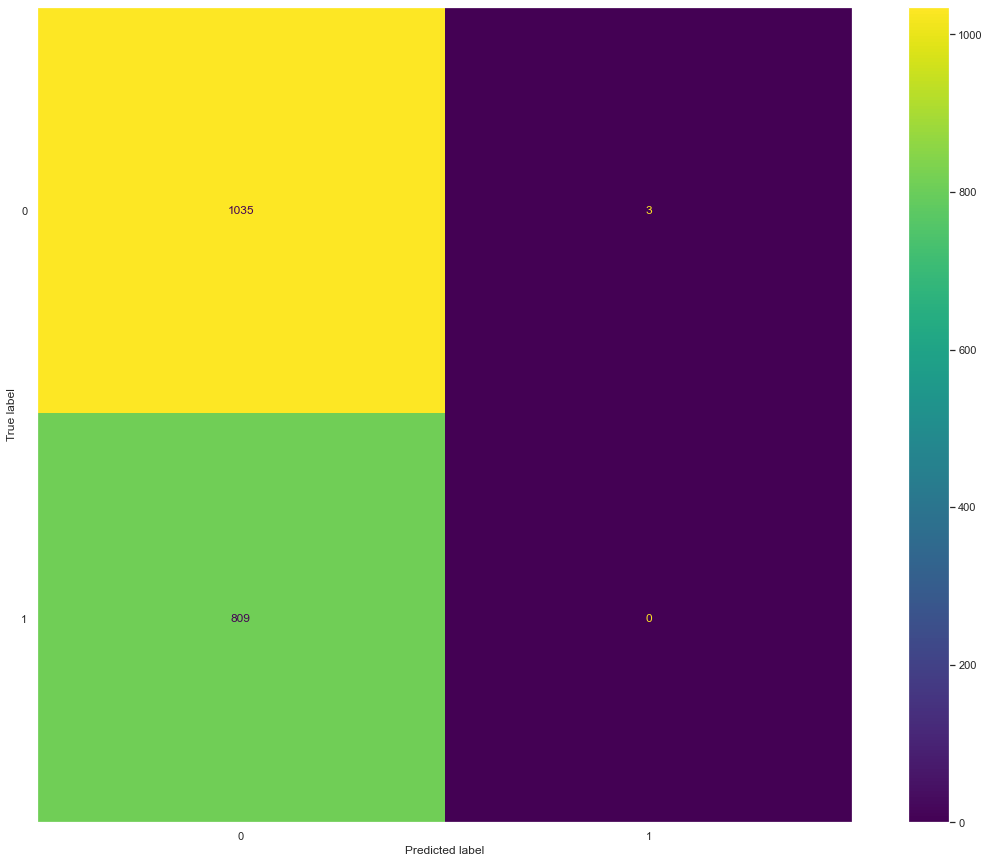

In [51]:
print("Confusion matrix on train set: ")
print(confusion_matrix(y_train, y_hat_train))
cm = confusion_matrix(y_train, y_hat_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

Acccuracy rate = ( TP + TN ) / Total = (1035+0)/1847 = 0.56 which means the model is correct to 56% and 44% of error rate.

So far, based on the results of accuraccy score and confusion matrix on test set and train set, the model do not bring out a good outcome of prediction since the error rate is pretty high.

However, the result shows that more new cases are caused by the community transmisison comparing to oversea travel.



### RFE 

In [52]:
#create RFE object
lr_model = LogisticRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [53]:
# doing evaluation
y_test_hat = rfe.predict(X_test)
print("accuracy score on test set: ", accuracy_score(y_test, y_test_hat))

accuracy score on test set:  0.5367965367965368


In [54]:
# summarize all features
for i in range(X_train.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000


In [55]:
# to increment number of features, one at each time
acc_scores = []
for i in range(1,10):
    clf = LogisticRegression()
    rfe = RFE(estimator=clf, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred)
    print("Acc on test set using", i, "features: ", acc_score)
    
    acc_scores.append(acc_score)

Acc on test set using 1 features:  0.5562770562770563
Acc on test set using 2 features:  0.5367965367965368
Acc on test set using 3 features:  0.5367965367965368
Acc on test set using 4 features:  0.5367965367965368
Acc on test set using 5 features:  0.5367965367965368
Acc on test set using 6 features:  0.5367965367965368
Acc on test set using 7 features:  0.5367965367965368
Acc on test set using 8 features:  0.5367965367965368
Acc on test set using 9 features:  0.5367965367965368


C:\Users\nguye\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nguye\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=2 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nguye\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
C:\Users\nguye\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_featur

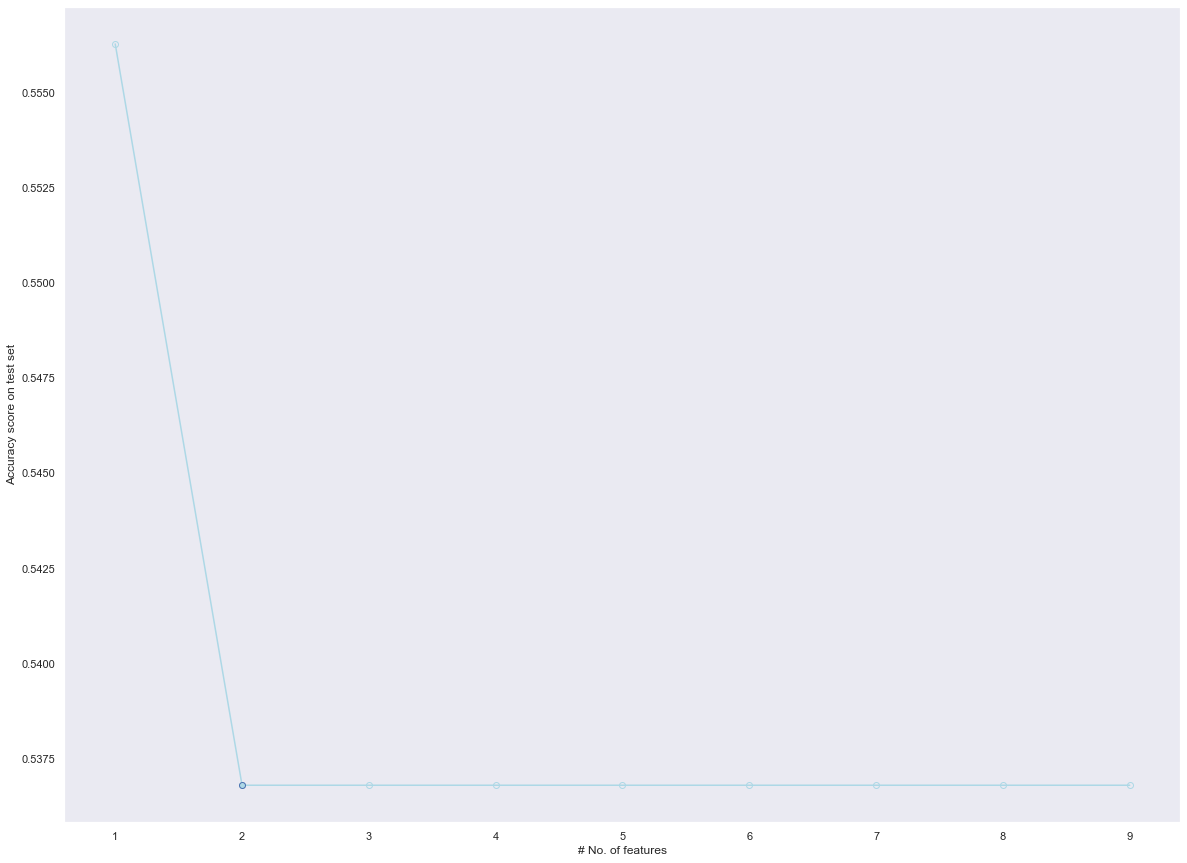

In [56]:
# Estimating accuracy score on test set using RFE by using different number of features
estimator = LogisticRegression()
acc_scores = []
for i in range(1, 10):
    selector = RFE(estimator, i)
    selector = selector.fit(X_train, y_train)
    supp = selector.get_support()

    predicted = selector.predict(X_test)
    acc_score = accuracy_score(y_test, predicted)
    acc_scores.append(acc_score)
  
best = 1
for item in acc_scores:
    if item < acc_scores[best - 1]:
        best = acc_scores.index(item) + 1

plt.grid()   
plt.xlabel('# No. of features')
plt.ylabel('Accuracy score on test set')
plt.plot(range(1, 10), acc_scores, marker = 'o', color = 'lightblue', markeredgewidth = 1 ,markeredgecolor = 'lightblue', markerfacecolor = 'None')
plt.plot(best, acc_scores[best-1], marker = 'o', markerfacecolor = 'lightblue')

## Linear Regression
Linear regression analysis is a statistical technique for predicting the value of one variable based on the value of another. In this part, we analyze the prediction between measure and new cases, in specify new cases in here will become the ouput. After that the result of mean squared error and r-squared will show the effective of model.

In [230]:
# Spliting data into training (80%) and testing(20%) with the random state is 142
train, test = train_test_split(case1, test_size=0.2, random_state=142)
print(train.shape)
print(test.shape)

(1847, 7)
(462, 7)


In [240]:
# choose the independent and denpendent variable
X_train = train[['new_cases','total_cases']]
Y_train = train ['MEASURE']
X_test = test[['new_cases','total_cases']]
Y_test = test['MEASURE']

In [241]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1847, 2) (1847,) (462, 2) (462,)


In [242]:
# Create Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)

LinearRegression()

In [243]:
print("y = x *", lr.coef_, "+", lr.intercept_)

y = x * [-5.35252877e-06 -5.20890428e-08] + 1.5341089927166336


In [244]:
predicted = lr.predict(X_test)
mse = mean_squared_error(Y_test, predicted)
r2 = r2_score(Y_test, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.22083288705842344
R Squared: 0.11185832933942352


In [246]:
predicted = lr.predict(X_train)
mse = mean_squared_error(Y_train, predicted)
r2 = r2_score(Y_train, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.22292025916220112
R Squared: 0.09439782887093262


In [247]:
predicted = lr.predict(X_test)
mse = mean_squared_error(Y_test, predicted)
print(mse)

0.22083288705842344


In the training:
* MSE: 0.222
* R squared: 0.094

In the testing:
* MSE: 0.221
* R squared: 0.111

Overall, to get the best model for prediction, the lowest MSE and the R squared nearly to 1. However in this part, we have the MSE is a good result, the lower MSE, the less error in the model and the better to forecast. MSE tells how close a regression line to a set of points. In the result of R squared, it shows the how well the regression model fits the observed data, so in this analysis, the model explains 10% of variation within data. 

Even the result of R squared is not well but the lower of MSE can show the positive area in the model. The 0.22 of MSE show that this model can forecast the relationship between measure and new cases.

## T-test sample

In [250]:
# Subset data
oversea = case.query('MEASURE == "Border closure"')
public = case.query('MEASURE == "Limit public gatherings"')

In [251]:
case.groupby('MEASURE').describe()

total_cases                                   \
                              count          mean           std  min   
MEASURE                                                                
Border closure               1286.0  1.310941e+06  1.882553e+06  3.0   
Limit public gatherings      1023.0  3.443224e+05  9.375089e+05  1.0   

                                                                   new_cases  \
                               25%       50%        75%        max     count   
MEASURE                                                                        
Border closure           122259.25  256234.5  1549556.5  8434997.0    1286.0   
Limit public gatherings   45840.50  214174.0   329090.5  8358792.0    1023.0   

                                       ...                   Percentage  \
                                 mean  ...      75%      max      count   
MEASURE                                ...                                
Border closure           13190.047434  ...  21181.5  76205.0     1286.0   
Limit public gatherings   4573.413490  ...   6166.0  69130.0     1023.0   

                                                                           \
                             mean       std       min       25%       50%   
MEASURE                                                                     
Border closure           0.035216  0.068209 -0.360436  0.005800  0.011318   
Limit public gatherings  0.042768  0.074892 -0.017205  0.006057  0.017297   

                                             
                              75%       max  
MEASURE                                      
Border closure           0.035783  0.666667  
Limit public gatherings  0.037645  0.666667  

[2 rows x 24 columns]

In [252]:
from statsmodels.stats.weightstats import ttest_ind

ttest_ind(oversea['new_cases'], public['new_cases'])

(14.850647467232344, 1.0254123872626182e-47, 2307.0)

statistic = 14.850647467232344 and p-value = 1.0254123872626182e-47

The result show that p-value < 0.05 that i can reject the null hypothesis and it is more meaningful for a predictor, so that this model is significant.

<AxesSubplot:xlabel='MEASURE', ylabel='new_cases'>

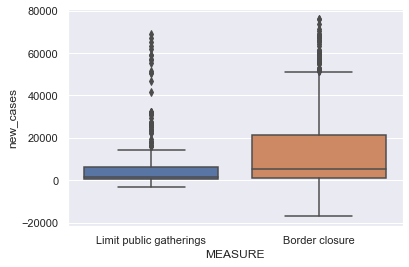

In [120]:
sns.boxplot(x='MEASURE', y='new_cases', data=case)

Look at the box plot, we can see the border closure is higher than limit public gatherings with the min is lower and the max is higher. The box of public has small gap but a lot of outlier outside which the number nearly equal to border closure. The gap of border closure is bigger and median is clearly. Overall to see this graph, we can see border closure has the number of new cases larger than limit public gathering.

<AxesSubplot:>

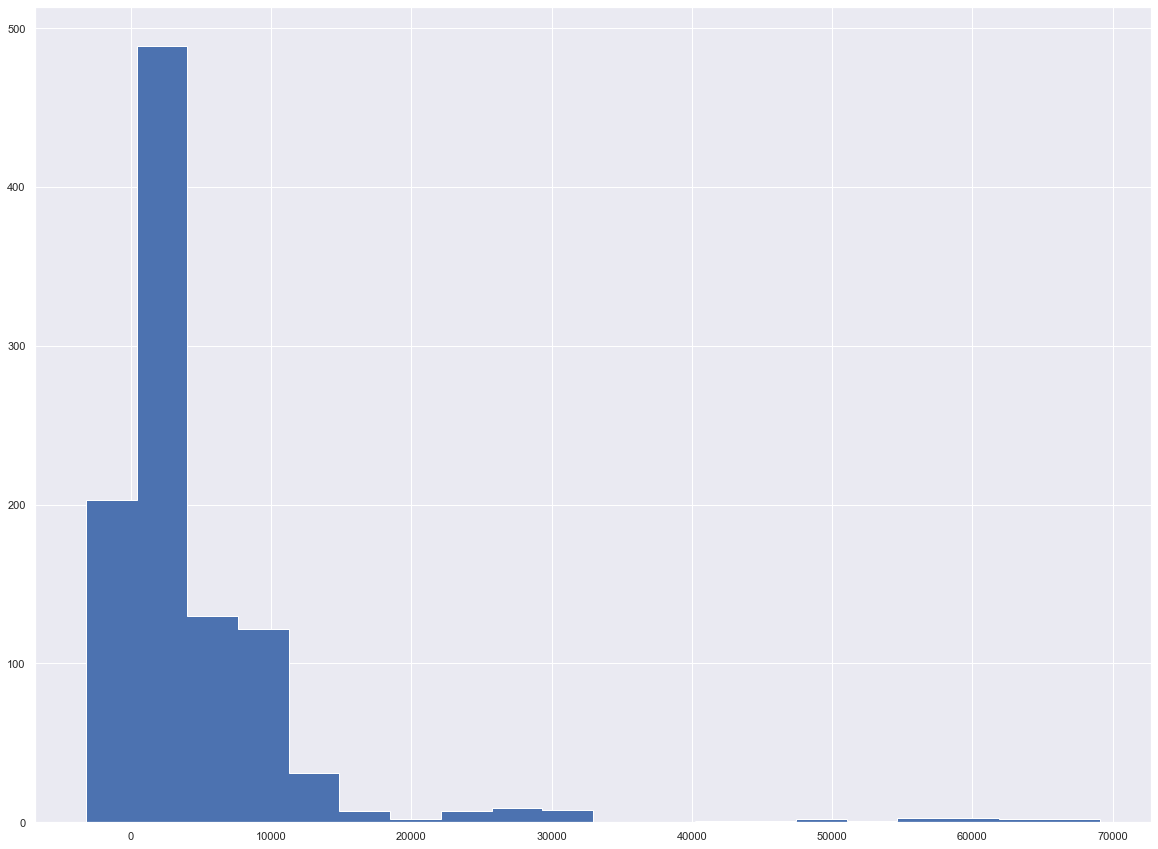

In [255]:
# the histogram of daily cases in the measure of limit public gatherings
public['new_cases'].hist(histtype = 'stepfilled', bins = 20)

<AxesSubplot:>

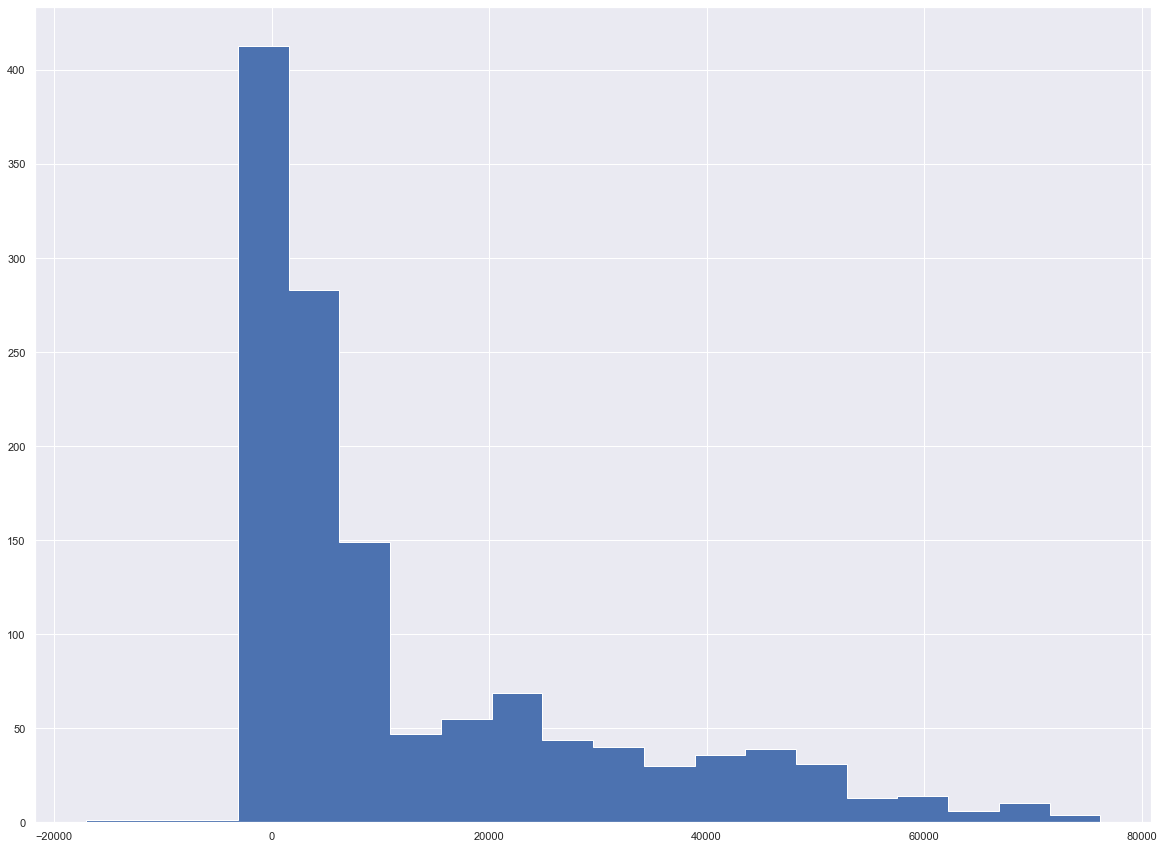

In [256]:
# the histogram of daily cases in the measure of border closure
oversea['new_cases'].hist(histtype = 'stepfilled', bins = 20)

Above is two histogram of border closure and limit public gatherings. A frequency distribution of limit public gathering smaller than border closure. The measure of daily cases in border closure seems bigger than these other.

## Conclusion

* The data visualizing shows us the difference between the effect of two measure which one can make the biggest effect to increasing covid cases. The border closure seems to be the reason to increasing cases while many graph in this report display its.
* However we cannot confirm the analysis through some graph, plots, method of prediction used in here to prove this model is suitable and appropriate to show that border closure is the reason we are looking for.
* The T test in here to show up that between border closure and limit public gatherings, closure is the one reason. Even in linear regression has a low R squared and a low p-value in t test. The model does not explain too much, but the data is significant. MSE is low to prove it still can have the best forecast

In the first report, we have already explain the way of analysis data and choose the measure. To figure out oversea travel or community transmission we use 2 measure reverse to show the result. When a country choose border closure, it means the control in the community is slightly more than when they are not closed the border. However when limit public gathering become the main control covid, the border still open and in their country, the spreading covid through community transmission is minimize and public gatherings is no longer is normal like the day without outbreak.

Hence the border closure implemented with the number of cases is larger than limit public gatherings, it shows the main reason to spreading the covid-19 fast is community transmission. Due to community transmission, the increasing of covid-19 cases.